### EU_email

In [2]:
import numpy as np
import pandas as pd
import random
import time
from sklearn.model_selection import RepeatedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy import linalg
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
import requests
%run GraphEncoder.ipynb
#from scipy.spatial import procrustes
import math

from graspologic.embed import AdjacencySpectralEmbed

/Users/tongqi/miniforge3/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/tongqi/miniforge3/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/tongqi/miniforge3/lib/python3.9/site-packages/umap/distances.py:1086: NumbaDeprecatio

In [3]:
import networkx as nx
from scipy.sparse import csr_array
from graspologic.simulations import rdpg
#from scipy.linalg import irlba
#from scipy.spatial import procrustes
%run GraphEncoder.ipynb
import leidenalg as la
import igraph as ig
import scipy.sparse as sp
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from gae.layers import GraphConvolution
from gae.model import GCNModelVAE
from gae.utils import load_data, mask_test_edges, preprocess_graph, get_roc_score
from gae.optimizer import loss_function

In [195]:
def adj_to_edg(A):
    """
      input is the symmetric adjacency matrix: A
      other variables in this function:
      s: number of edges
      return edg_list -- matrix format with shape(edg_sum,3):
      example row in edg_list(matrix): [vertex1, vertex2, connection weight from Adj matrix]
    """
    # check the len of the second dimenson of A
    if A.shape[1] <= 3:
      edg = A
    else:
      n = A.shape[0]
      # construct the initial edgg_list matrix with the size of (edg_sum, 3)
      edg_list = []
      for i in range(n):
        for j in range(i, n):
          if A[i,j] > 0:
            row = [i, j, A[i,j]]
            edg_list.append(row)
      edg = np.array(edg_list)
    return edg

def procrustes(X, Y, type="I"):
    if type == "C":
        X = X / np.linalg.norm(X, ord="fro") * np.sqrt(X.shape[0])
        Y = Y / np.linalg.norm(Y, ord="fro") * np.sqrt(Y.shape[0])
    if type == "D":
        tX = np.sum(X ** 2, axis=1)
        tX[tX <= 1e-15] = 1
        tY = np.sum(Y ** 2, axis=1)
        tY[tY <= 1e-15] = 1
        X = X / np.sqrt(tX)[:, np.newaxis]
        Y = Y / np.sqrt(tY)[:, np.newaxis]

    tmp = X.T @ Y
    U, s, Vt = np.linalg.svd(tmp,full_matrices=False)
    W = U @ Vt.T
    error = np.linalg.norm(X @ W - Y, ord="fro")
    
    return {"error": error, "W": W}


In [196]:
def GCN_emb(model, features, adj_norm_matrix, adj_label,n, decay,learning_rate, epochs = 200):
    optimizer = torch.optim.Adam(
      model.parameters(),
      lr=learning_rate,
      weight_decay=decay) #weight decay is important!

    # get class weight
    pos_weight = ((adj_label.shape[0] * adj_label.shape[0] - adj_label.sum()) / adj_label.sum())
    # get adj norm
    adj_norm = adj_label.shape[0] * adj_label.shape[0] / float((adj_label.shape[0] *adj_label.shape[0] - adj_label.sum()) * 2)

    # Training the VAE   
    while True: #we can try 20 different random weight init runs to get an average 
        # initialize weights randomly => impact on convergence
        model.gc1.reset_parameters()
        model.gc2.reset_parameters()
        model.gc3.reset_parameters()  
        # Training
        for epoch in range(0, epochs + 1):
            model.train()
            optimizer.zero_grad()
            # ===================forward=====================
            adj_hat, mu, logvar = model(features,adj_norm_matrix)        
            loss = loss_function(adj_hat,adj_label,mu,logvar,n,adj_norm,pos_weight) #might reduce the KL term regularization
            # log
            if epoch == 0:
              init_loss = loss.item()
            # if epoch% 50 == 0:
            #   print('loss: ', loss.item())
            # ===================backward====================
            loss.backward()
            optimizer.step()
        # Check convergence
        if (init_loss-loss.item())/loss.item() > 0.05: 
            break
        else:
          print(model)
          print('not converged yet, reset params and rerun')

  # Get GCN embedding
    with torch.no_grad():
      model.eval()
      adj_hat, mu, logvar = model(features, adj_norm_matrix)
      z = model.reparameterize(mu, logvar) 

    return z

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

def preprocess_graph(adj_):
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten()) #D^-0.5
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()  #D^-0.5 A D^-0.5
    return sparse_mx_to_torch_sparse_tensor(adj_normalized), sparse_mx_to_torch_sparse_tensor(adj_)

def adj_in_out(adj):
    row, col = np.where(adj)
    coo = np.rec.fromarrays([row, col, adj[row, col]], names='row col value'.split())
    out = sp.coo_matrix((coo['value'], (coo['row'], coo['col'])), (adj.shape[0], adj.shape[1]))
    #Adjacency normalized matrix and label for GVAE usage
    adj_norm_matrix, adj_matrix = preprocess_graph(out)
    adj_label = torch.FloatTensor(out.toarray())
    return adj_norm_matrix, adj_matrix, adj_label#, out

In [185]:
row, col = np.where(adj0)
coo = np.rec.fromarrays([row, col, adj0[row, col]], names='row col value'.split())
out = sp.coo_matrix((coo['value'], (coo['row'], coo['col'])), (adj0.shape[0], adj0.shape[1]))
    #Adjacency normalized matrix and label for GVAE usage
adj_norm_matrix, adj_matrix = preprocess_graph(out)
adj_label = torch.FloatTensor(out.toarray())

In [194]:
sum(adj_label[:,4])
adj_matrix

tensor(indices=tensor([[   0,    0,    0,  ..., 1002, 1003, 1004],
                       [   0,    1,    5,  ...,  560,  258,   55]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       size=(1005, 1005), nnz=32770, layout=torch.sparse_coo)

In [197]:
df = pd.read_csv (r'/Users/tongqi/Desktop/papersandbooks/codes/GEE_ASE/data/email-Eu-core-department-labels.txt',
                  sep = ' ', header = None)
y = df.to_numpy()
ys= y[:,1].reshape((len(y[:,1]),1))
print(len(y[:,1]))
#len(np.unique(y[:,1]))

1005


In [198]:
df2 = pd.read_csv (r'/Users/tongqi/Desktop/papersandbooks/codes/GEE_ASE/data/email-Eu-core.txt',
                   header = None,sep = ' ')
Edge = df2.to_numpy()
print(Edge)

[[  0   1]
 [  2   3]
 [  2   4]
 ...
 [440 460]
 [ 52 786]
 [506 932]]


In [199]:
A0 = np.zeros((1005,1005))
for i in range (0,25571):
    A0[Edge[i,0],Edge[i,1]]=1
#print(A0)
A0.astype(int)

array([[1, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [200]:
n=len(y[:,1])
K=int(y.max())
edgelist0 = adj_to_edg(A0)

d=2 # from R getElbow

graph0 = nx.from_numpy_matrix(A0,parallel_edges=False, create_using=None)
adj0 = nx.to_numpy_array(graph0, dtype=int)
ase = AdjacencySpectralEmbed(n_components=d, algorithm='truncated')
ASE_Xhat0 = ase.fit_transform(adj0)
# EncoderLDA(A)
Z0, W0 = graph_encoder_embed(edgelist0,ys,n,Correlation= False)
Z0.shape

/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)


(1005, 42)

In [201]:
clique_sizes = [math.log(n),math.log(n)**2, 0.08*n,0.1*n,0.15*n,0.2*n]
clique_sizes = [ int(x) for x in clique_sizes ]
print(clique_sizes)


[6, 47, 80, 100, 150, 201]


In [207]:
GEE_dist = []
ASE_dist = []
GAE_dist = []
n_c = []
EU_data = []

sim = 50
random.seed(118)

for clique in clique_sizes:
    for i in range(sim):
        # Generate a complete graph for the first log(n[k])^2 vertices
        c_vertices = random.sample(range(0,n),clique) 
        full_g = nx.complete_graph(c_vertices)

        # Get the edges of the complete graph
        full_edges = list(full_g.edges())
        edges = list(graph0.edges()) 
        all_edges = set(edges).union(set(full_edges))

        graph1 = nx.Graph(all_edges)

        # Check if nodes are connected in both graphs
         #print(graph0.has_edge(0, 4))
         #print(graph1.has_edge(0, 4))


        adj1 = nx.to_numpy_array(graph1, dtype=int)

        edgelist1 =  adj_to_edg(adj1)
        Z1, W1 = graph_encoder_embed(edgelist1,ys,n,Correlation= False)
        #%%%%%%%% GEE dist
        GEEd = procrustes(Z1,Z0)['error']
        GEE_dist.append(GEEd)

        #%%%%%%% ASE dist
         #ASE_Xhat0 = ase.fit_transform(adj0)
        ASE_Xhat1 = ase.fit_transform(adj1)

        ASE_d = procrustes(ASE_Xhat1,ASE_Xhat0)['error']
        ASE_dist.append(ASE_d)

        #%%%%%%%%%%%%%%%%% GAE
        dim = d
        features = torch.eye(n)
        model_GAE = GCNModelVAE(n, 2*dim, dim, 0) #init new instance everytime. Can change 0 to other dropout rates

        adj0 = nx.to_numpy_array(graph0, dtype=int)
        adj_norm_matrix0, adj_matrix0, adj_label0 = adj_in_out(adj0)
        GAE_0 = GCN_emb(model_GAE, features, adj_norm_matrix0, adj_label0,n,decay=0, learning_rate=1e-2) #initial benchmark: decay = 1e-3; investigate 0 weight decay w/ dropout on 
        GAE_0 = GAE_0.numpy()
        adj1 = nx.to_numpy_array(graph1, dtype=int)
        adj_norm_matrix1, adj_matrix1, adj_label1 = adj_in_out(adj1)
        GAE_1 = GCN_emb(model_GAE, features, adj_norm_matrix1, adj_label1,n,decay=0, learning_rate=1e-2) #initial benchmark: decay = 1e-3; investigate 0 weight decay w/ dropout on 
        GAE_1 = GAE_1.numpy()
        GAE_d = procrustes(GAE_1,GAE_0)
        GAE_d = GAE_d['error']
        GAE_dist.append(GAE_d)

        n_c.append(clique)
        df_id = str(clique)
        
    sim_data = np.column_stack((ASE_dist, GEE_dist,GAE_dist,n_c))
    sim_data = pd.DataFrame(sim_data, columns = ['ASE_dist','GEE_dist','GAE_dist','n_c'])
    sim_data.to_csv("./sim_data/EU"+df_id+".csv", sep=',', index=False)
EU_data.append(sim_data)


print(EU_data)



/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: 

GCNModelVAE(
  (gc1): GraphConvolution (1005 -> 4)
  (gc2): GraphConvolution (4 -> 2)
  (gc3): GraphConvolution (4 -> 2)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun


/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: 

GCNModelVAE(
  (gc1): GraphConvolution (1005 -> 4)
  (gc2): GraphConvolution (4 -> 2)
  (gc3): GraphConvolution (4 -> 2)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun


/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: 

GCNModelVAE(
  (gc1): GraphConvolution (1005 -> 4)
  (gc2): GraphConvolution (4 -> 2)
  (gc3): GraphConvolution (4 -> 2)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun


/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: 

GCNModelVAE(
  (gc1): GraphConvolution (1005 -> 4)
  (gc2): GraphConvolution (4 -> 2)
  (gc3): GraphConvolution (4 -> 2)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun


/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: 

/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: 

/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: 

/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: 

/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: 

/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)


GCNModelVAE(
  (gc1): GraphConvolution (1005 -> 4)
  (gc2): GraphConvolution (4 -> 2)
  (gc3): GraphConvolution (4 -> 2)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun


/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: 

GCNModelVAE(
  (gc1): GraphConvolution (1005 -> 4)
  (gc2): GraphConvolution (4 -> 2)
  (gc3): GraphConvolution (4 -> 2)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun


/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: 

GCNModelVAE(
  (gc1): GraphConvolution (1005 -> 4)
  (gc2): GraphConvolution (4 -> 2)
  (gc3): GraphConvolution (4 -> 2)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun


/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: 

GCNModelVAE(
  (gc1): GraphConvolution (1005 -> 4)
  (gc2): GraphConvolution (4 -> 2)
  (gc3): GraphConvolution (4 -> 2)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun


/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: 

GCNModelVAE(
  (gc1): GraphConvolution (1005 -> 4)
  (gc2): GraphConvolution (4 -> 2)
  (gc3): GraphConvolution (4 -> 2)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun


/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: 

GCNModelVAE(
  (gc1): GraphConvolution (1005 -> 4)
  (gc2): GraphConvolution (4 -> 2)
  (gc3): GraphConvolution (4 -> 2)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun


/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: 

[      ASE_dist   GEE_dist   GAE_dist    n_c
0    11.501154  23.510763  24.270561    6.0
1    11.500999  23.413216  24.821598    6.0
2    11.537776  24.254018  23.644011    6.0
3    11.543669  24.554714  32.313946    6.0
4    11.516272  23.985053  18.114000    6.0
..         ...        ...        ...    ...
295  15.798597  32.405352  44.577370  201.0
296  15.378077  32.989991  33.828793  201.0
297  15.369338  30.604882  32.120293  201.0
298  15.301233  33.107739  12.830085  201.0
299  15.484830  32.474328  38.873188  201.0

[300 rows x 4 columns]]


In [208]:
print(EU_data)

[      ASE_dist   GEE_dist   GAE_dist    n_c
0    11.501154  23.510763  24.270561    6.0
1    11.500999  23.413216  24.821598    6.0
2    11.537776  24.254018  23.644011    6.0
3    11.543669  24.554714  32.313946    6.0
4    11.516272  23.985053  18.114000    6.0
..         ...        ...        ...    ...
295  15.798597  32.405352  44.577370  201.0
296  15.378077  32.989991  33.828793  201.0
297  15.369338  30.604882  32.120293  201.0
298  15.301233  33.107739  12.830085  201.0
299  15.484830  32.474328  38.873188  201.0

[300 rows x 4 columns]]


In [250]:
data = np.reshape(EU_data, (len(n_c), 4))
df = pd.DataFrame(data)
df.columns =['ASE','GEE','GAE','Clique']
meltdf = pd.melt(df, id_vars=['Clique'], var_name='variable', value_name='value')
summary_functions = {'value': ['min', 'mean', 'max', 'std']}
finaldf = meltdf.groupby(['Clique', 'variable']).agg(summary_functions)
finaldf.columns = ['_'.join(col).strip() for col in finaldf.columns.values]
finaldf.reset_index(inplace=True)
finaldf['Clique'] = finaldf['Clique'].astype(int)
finaldf.loc[finaldf['Clique'] ==6  , 'Cliquesize'] = 'log(n)'
finaldf.loc[finaldf['Clique'] == 47, 'Cliquesize'] = 'log(n)^2'
finaldf.loc[finaldf['Clique'] == 80, 'Cliquesize'] = '0.08*n'
finaldf.loc[finaldf['Clique'] == 100, 'Cliquesize'] = '0.1*n'
finaldf.loc[finaldf['Clique'] == 150, 'Cliquesize'] = '0.15*n'
finaldf.loc[finaldf['Clique'] == 201, 'Cliquesize'] = '0.2*n'
finaldf

,Clique,variable,value_min,value_mean,value_max,value_std,Cliquesize
0,6,ASE,11.486923,11.547713,11.867343,0.083683,log(n)
1,6,GAE,18.114000,31.390815,46.867714,8.516542,log(n)
2,6,GEE,22.590142,23.615092,24.554714,0.471029,log(n)
3,47,ASE,11.446348,11.918917,12.204429,0.144982,log(n)^2
4,47,GAE,11.813250,31.395531,47.690826,10.447273,log(n)^2
5,47,GEE,22.482470,23.935404,25.060330,0.655286,log(n)^2
6,80,ASE,12.564921,12.846357,13.141637,0.137540,0.08*n
7,80,GAE,14.103913,30.563425,45.723042,8.819472,0.08*n
8,80,GEE,23.778610,25.051767,26.347141,0.750420,0.08*n
9,100,ASE,12.944244,13.383080,13.659399,0.169916,0.1*n


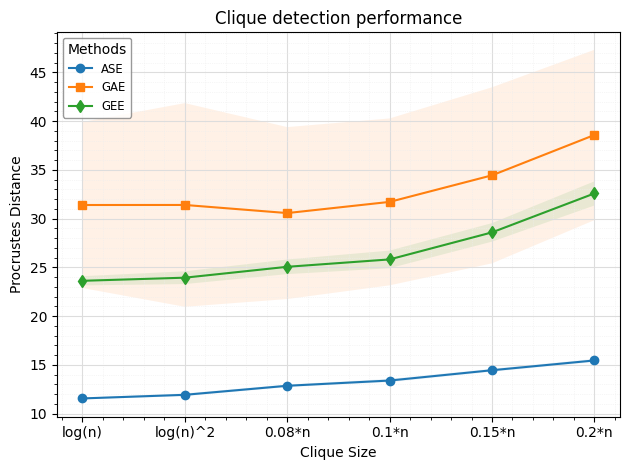

In [246]:
# CAUTION

fig, ax = plt.subplots()
#fig.patch.set_facecolor("#fafafa")
#ax.set_facecolor("#fafafa")

for item in [fig, ax]:
    item.patch.set_visible(True)

for variable, group in finaldf.groupby('variable'):
    ax.plot(group['Cliquesize'], group['value_mean'], label=variable)
    ax.fill_between(group['Cliquesize'], group['value_mean'] - group['value_std'], 
                    group['value_mean'] + group['value_std'], alpha=0.1)
    ax.grid(True)
    ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
    ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax.minorticks_on()
    

ax.set(xlabel='Clique Size', ylabel='Procrustes Distance',
       title='Clique detection performance')
# ax.set_facecolor("white")

# set markers
markers = ['o', 's', 'd']
for i, line in enumerate(ax.get_lines()):
    line.set_marker(markers[i])

#ax.legend(ax.get_lines(), finaldf.columns, loc='upper left', ncol=2)

plt.tight_layout()

legend = plt.legend(frameon = 1,loc = 2,title="Methods",fontsize='small',fancybox=True )
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')

#plt.show()
#plt.savefig('./plots/EU_email.png')

# plots for normalized and regular Procrustes distance

In [25]:
# CAUTION 
# read dataset
#readdata = genfromtxt('./sim_data/sim_data_nml_dirichletlog(n)^21500.csv', delimiter=',')
readdata = pd.read_csv ('./sim_data/rdm_nml_dirichlet3rdpgloglog(n)1500.csv',sep=',')
#data = np.reshape(readdata, (sim*len(nvs), 7))
#df = pd.DataFrame(data)
readdata.columns =['ASE_dist','GEE_dist','VGAE_dist','ASE_nml','GEE_nml','VGAE_nml','N']
distdf = readdata[['ASE_dist','GEE_dist','VGAE_dist','N']]
meltdf = pd.melt(distdf, id_vars=['N'], var_name='variable', value_name='value')
summary_functions = {'value': ['min', 'mean', 'max', 'std']}
finaldf = meltdf.groupby(['N', 'variable']).agg(summary_functions)
finaldf.columns = ['_'.join(col).strip() for col in finaldf.columns.values]
finaldf.reset_index(inplace=True)
#finaldf['D_R'] = finaldf['variable'].apply(lambda x: 'Dist' if x in ['GEE_dist', 'ASE_dist', 'GAE_dist'] else 'Normalized')

# get sub-dataframe for the distance plot
nmldf = readdata[['ASE_nml','GEE_nml','VGAE_nml','N']]
nmldf.head(3)


,ASE_nml,GEE_nml,VGAE_nml,N
0,0.123449,0.295776,0.061435,100.0
1,0.121699,0.315932,0.042948,100.0
2,0.128037,0.172559,0.027874,100.0


In [7]:
cliquesize = cliquesize = f'log(n)'

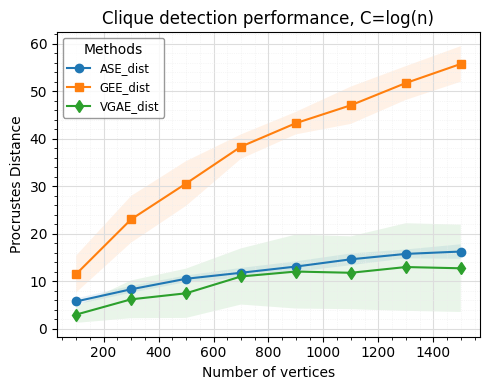

In [26]:
# CAUTION

fig, ax = plt.subplots(figsize=(5, 4))
#fig.patch.set_facecolor("#fafafa")
#ax.set_facecolor("#fafafa")

for item in [fig, ax]:
    item.patch.set_visible(True)

for variable, group in finaldf.groupby('variable'):
    ax.plot(group['N'], group['value_mean'], label=variable)
    ax.fill_between(group['N'], group['value_mean'] - group['value_std'], 
                    group['value_mean'] + group['value_std'], alpha=0.1)
    ax.grid(True)
    ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
    ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax.minorticks_on()
    

ax.set(xlabel='Number of vertices', ylabel='Procrustes Distance', 
       title='Clique detection performance, C='+cliquesize)
# ax.set_facecolor("white")

# set markers
#markers = ['o', 's', 'd','v','x','8']
markers = ['o', 's', 'd']
for i, line in enumerate(ax.get_lines()):
    line.set_marker(markers[i])

#ax.legend(ax.get_lines(), finaldf.columns, loc='upper left', ncol=2)

plt.tight_layout()

legend = plt.legend(frameon = 1,loc = 2,title="Methods",fontsize='small',fancybox=True )
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')

plt.show()
#plt.savefig('./plots/rdm_diri_3rdpglogn' + cliquesize + '.png')


In [13]:
# get the normalized sub datafile
nmldf = readdata[['ASE_nml','VGAE_nml','GEE_nml','N']]
meltdf = pd.melt(nmldf, id_vars=['N'], var_name='variable', value_name='value')
summary_functions = {'value': ['min', 'mean', 'max', 'std']}
finaldf = meltdf.groupby(['N', 'variable']).agg(summary_functions)
finaldf.columns = ['_'.join(col).strip() for col in finaldf.columns.values]
finaldf.reset_index(inplace=True)

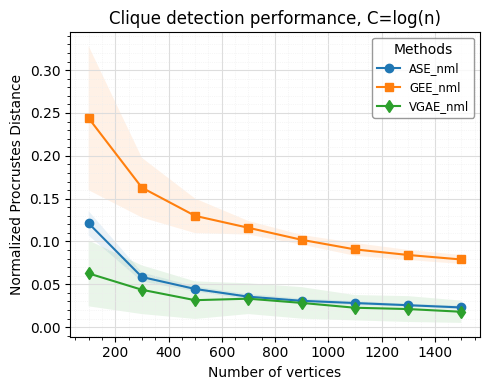

In [23]:
# CAUTION
# for normalized plots
fig, ax = plt.subplots(figsize=(5, 4))
#fig.patch.set_facecolor("#fafafa")
#ax.set_facecolor("#fafafa")

for item in [fig, ax]:
    item.patch.set_visible(True)

for variable, group in finaldf.groupby('variable'):
    ax.plot(group['N'], group['value_mean'], label=variable)
    ax.fill_between(group['N'], group['value_mean'] - group['value_std'], 
                    group['value_mean'] + group['value_std'], alpha=0.1)
    ax.grid(True)
    ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
    ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax.minorticks_on()
    

ax.set(xlabel='Number of vertices', ylabel='Normalized Procrustes Distance', 
       title='Clique detection performance, C='+cliquesize)
# ax.set_facecolor("white")

# set markers
#markers = ['o', 's', 'd','v','x','8']
markers = ['o', 's', 'd']
for i, line in enumerate(ax.get_lines()):
    line.set_marker(markers[i])

#ax.legend(ax.get_lines(), finaldf.columns, loc='upper left', ncol=2)

plt.tight_layout()

legend = plt.legend(frameon = 1,loc = 1,title="Methods",fontsize='small',fancybox=True )
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')


plt.show()
#plt.savefig('./plots/rdm_diri_3rdpglogn' + cliquesize + '.png')
